Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

{'C': 1.4795816345422876, 'gamma': 0.006576107192827539, 'kernel': 'rbf'}
SVM train 정확도: 1.0000
SVM test 정확도: 0.8889
SVM total 정확도: 0.9778
SVM others 정확도: 0.9762
[[19  0  0  0]
 [ 0  2  0  0]
 [ 0  0 28  0]
 [ 0  0  0 23]]
[[6 0 0 0]
 [1 0 0 0]
 [0 0 7 1]
 [0 0 0 3]]
[[25  0  0  0]
 [ 1  2  0  0]
 [ 0  0 35  1]
 [ 0  0  0 26]]
[[41  0  0  1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


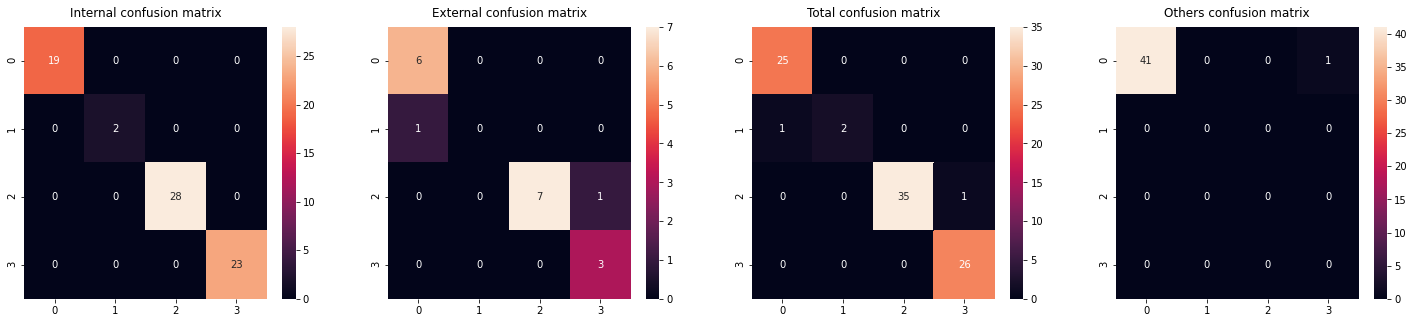

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, MaxAbsScaler,  QuantileTransformer
from tensorflow.python.keras.utils import np_utils
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.utils.fixes import loguniform
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from google.colab import drive
drive.mount('/content/drive')

seed=0
np.random.seed(seed)

#데이터 입력
df = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/PA/MORDRED_2D/PA_morgan_2D_apppendscore_dropsmiles.csv')
data = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/PA/MORDRED_2D/PAOthers_morgan_2D_apppendscore_dropsmiles.csv')

#데이터 분류
dataset = df.values
X = dataset[:,0:-1]
Y = dataset[:,-1]

data = data.values
X_others =data[:,0:-1]
Y_others =data[:,-1]

#복합샘플링

smote = SMOTEENN( random_state=seed)
X_over, Y_over = smote.fit_sample(X, Y)

#X 표준화

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_over)
X_others_scaled = scaler.transform(X_others)
#totX_scaled = scaler.transform(totX)

#PCA로 차원 줄이기

#pca = PCA(n_components=3)
#X_pca = pca.fit_transform(X_scaled)
#exX_pca = pca.transform(exX_scaled)
#totX_pca = pca.transform(totX_scaled)

#데이터 split

train_input, test_input, train_target, test_target = train_test_split(X_scaled, Y_over, test_size=0.2, random_state=seed)

#SVM 모델

param_grid = [{'kernel':['poly','rbf','linear','sigmoid'],  'C': loguniform(1, 1e3), 'gamma': loguniform(1e-3, 1)}]
grid =RandomizedSearchCV(SVC(random_state=seed), param_grid, n_jobs=-1, n_iter=100, cv=5, scoring='accuracy')
grid.fit(train_input, train_target)

pred_train = grid.predict(train_input)
pred_test = grid.predict(test_input)
pred_total = grid.predict(X_scaled)
pred_others = grid.predict(X_others_scaled)
accuracy = accuracy_score(train_target, pred_train)
ex_accuracy = accuracy_score(test_target, pred_test)
tot_accuracy = accuracy_score(Y_over, pred_total)
others_accuracy = accuracy_score(Y_others, pred_others)

print(grid.best_params_)

print('SVM train 정확도: {0:.4f}'.format(accuracy))
print('SVM test 정확도: {0:.4f}'.format(ex_accuracy))
print('SVM total 정확도: {0:.4f}'.format(tot_accuracy))
print('SVM others 정확도: {0:.4f}'.format(others_accuracy))

conf = confusion_matrix(train_target, pred_train, labels=[0,1,2,3])
exconf = confusion_matrix(test_target, pred_test, labels=[0,1,2,3])
totconf = confusion_matrix(Y_over, pred_total, labels=[0,1,2,3])
othersconf = confusion_matrix(Y_others, pred_others, labels=[0,1,2,3])

print(conf)
print(exconf)
print(totconf)
print(othersconf)

#def report(results, n_top=20):
#    for i in range(1, n_top + 1):
#        candidates = np.flatnonzero(results['rank_test_score'] == i)
#        for candidate in candidates:
#            print("Model with rank: {0}".format(i))
#            print("Parameters: {0}".format(results['params'][candidate]))
#            print("") #여기에 accu, conf 추가해야 함
            
#report(grid.cv_results_)    

#모델 저장 

svm = grid.best_estimator_

saved_model = joblib.dump(svm,'/content/drive/MyDrive/Inhibitor classification/Inhibitor/PA/PA_SVC_0407_02.pkl')

#standard scaling만:0.5(MinMax도) Normalizer만:0.6(0.5, 0.6, 0.53) Binarizer만: 0.4 RobustScaler만:0.65 스케일링은 RobustScaler로

#0331: Robust만 시행 0331_2: Robust, kernel='linear', C=1 0331_3: Robust, kernal rbf, C=36, gamma=202 0.91 0.45 0.83 0331_4: Robust, kernal rbf, C=0.509, gamma=880 random_state=52, pca component 3 0.50 0.65 0.53

#0401_1 0.91 0.45 0.83

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(25, 5))
sns.heatmap(conf, annot=True, ax=ax[0])
ax[0].set_title('Internal confusion matrix', pad = 10)
sns.heatmap(exconf, annot=True, ax=ax[1])
ax[1].set_title('External confusion matrix', pad = 10)
sns.heatmap(totconf, annot=True, ax=ax[2])
ax[2].set_title('Total confusion matrix', pad = 10)
sns.heatmap(othersconf, annot=True, ax=ax[3])
ax[3].set_title('Others confusion matrix', pad = 10)

plt.show()

In [ ]:
import numpy as np
from scipy.stats import uniform, randint

print(list(np.random.uniform(1e-5, 1e-3, 10)))

[0.00032431103854232876, 0.0002569857755565161, 1.9452636506587898e-05, 0.0009613101071468497, 0.000982653877723231, 0.000335438593429017, 0.0008188208385819378, 0.0009561577769412733, 9.746641764669242e-05, 8.913198695179469e-05]


In [ ]:
#SVM 파리미터 튜닝(SVC)

import pandas as pd
import tensorflow as tf
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.python.keras.utils import np_utils
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.feature_selection import SelectFromModel, f_classif, mutual_info_classif, SelectKBest, VarianceThreshold, SelectPercentile
from scipy.stats import uniform, randint
from sklearn.utils.fixes import loguniform


#데이터 입력
df = pd.read_csv('./VRK2_inhibitor_descriptor_Internal_dataset_dropunmane.csv')
df2 = pd.read_csv('./VRK2_inhibitor_descriptor_external_dataset_dropunmane.csv')
df3 = pd.concat([df, df2])

#데이터 분류
dataset = df.values
X = dataset[:,0:-1]
Y = dataset[:,-1]

dataset2 = df2.values
exX = dataset[:,0:-1]
exY = dataset[:,-1]

dataset3 = df3.values
totX = dataset[:,0:-1]
totY = dataset[:,-1]

#X 정규화

scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)
exX_scaled = scaler.transform(exX)
totX_scaled = scaler.transform(totX)

#학습셋과 테스트셋을 나눔

#X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=10)

#SVM 모델튜닝
#param_grid = {'C': np.arange(0.000015, 0.000005, 0.000001), 'gamma': np.arange(0.0000001, 0.000001, 0.0000001),
#              'kernel': ['linear','rbf','poly','sigmoid']}
#svm = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
#svm.fit(X_train, Y_train)

#print(svm.best_params_)

#pred_train = svm.predict(X_train)
#pred_test = svm.predict(X_test)
#pred_accuracy = accuracy_score(Y_test, pred_test)

#파이프라인 생성
sel = SelectKBest()
clf = SVC()
step = [('sel',sel), ('svc', clf) ]
pipeline = Pipeline(step)
parameter =[{'sel__k':randint(10, 3330), 'svc__C': ran}]

print(pipeline.get_params().keys())
 
grid = RandomizedSearchCV(pipeline, parameter, n_iter=5, cv=5, scoring = 'accuracy', n_jobs = -1)
grid.fit(X_scaled, Y)

print("Best Parameters : ", grid.best_params_)
print("Best Score : ", grid.best_score_)

grid_clf = grid.best_estimator_
grid_clf.fit(X_scaled, Y)

print('테스트 정확도: %.3f'% grid_clf.score(exX_scaled, exY))
print('total 정확도: %.3f'% grid_clf.score(totX_scaled, totY))

# Save best grid search pipeline to file
saved_model_svc = joblib.dump(grid_clf,'./VRK2_svc5.pkl')
#{'C': 1e-05, 'gamma': 1e-07, 'kernel': 'poly'} SVM 정확도: 0.7143 

#피처별 중요도 알아봐야함

dict_keys(['memory', 'steps', 'verbose', 'sel', 'svc', 'sel__k', 'sel__score_func', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])
Best Parameters :  {'sel__k': 866}
Best Score :  0.5133333333333334
테스트 정확도: 0.731
total 정확도: 0.731


C:\Users\eunwoo\.conda\envs\Tensorflow\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\eunwoo\.conda\envs\Tensorflow\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  41  363 1223 1507 1510 2355 2374 2680 2685 2690 2694 2705 2722 2752
 2757 2761 2783 2806 2828 2849 2860 2885 2895 2903 2919 2921 2923 2928
 2929 2930 2931 2932 2937 2941 2946 2951 2956 2957 2961 2962 2967 2970
 2972 2973 2976 2983 2990 2998 3000 3007 3009 3018 3019 3020 3021 3027
 3036 3046 3047 3051 3057 3060 3062 3066 3073 3080 3088 3090 3097 3099
 3108 3110 3170 3171 3185 3186 3187 3188 3195 3196 3198 3202 3214 3215
 3216 3217 3218 3219 3221 3235 3236 3237 3238 3248 3250 3251 3252 3256
 3260 3261 3262 3277 3278 3279 3280 3282 3283 3284 3296 3297 3298 3299
 3300 3302 3310 3311 3312 3313 3314 3315 331

In [ ]:
#SVM 파리미터 튜닝(LinearSVC)

import pandas as pd
import tensorflow as tf
import joblib


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.utils import np_utils
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.feature_selection import SelectFromModel, f_classif, mutual_info_classif, SelectKBest, VarianceThreshold, SelectPercentile
from scipy.stats import uniform, randint

#데이터 입력
df = pd.read_csv('./VRK2_inhibitor_descriptor_dropfinal_withoutSMILES_appendclass_dropunmane.csv')

#데이터 분류
dataset = df.values
X = dataset[:,0:-1]
Y = dataset[:,-1]

#X 정규화

scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)

#학습셋과 테스트셋을 나눔

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=10)

#파이프라인 생성

sel = SelectKBest() #K는 130 혹은 119
clf = LinearSVC()
step = [('sel',sel), ('clf', clf) ]
pipeline = Pipeline(step)
parameter = {'sel__k':randint(10, 3330), 'clf__penalty': ['l2'], 'clf__max_iter': [18], 'clf__loss':['squared_hinge'],
            'clf__dual':[True], 'clf__C': [0.8], 'clf__multi_class':['ovr'], 'clf__fit_intercept': [True],
            'clf__intercept_scaling': [0.72362], 'clf__random_state': [0]}
grid = RandomizedSearchCV(pipeline, parameter, n_iter=100000, cv=5, scoring = 'accuracy', n_jobs = -1)
grid.fit(X_train, Y_train)
saved_model_svc = joblib.dump(grid,'./VRK2_linearsvc2.pkl')

print("Best Parameters : ", grid.best_params_)
print("Best Score : ", grid.best_score_)
print("Best Test Score : ", grid.score(X_test, Y_test))


Best Parameters :  {'clf__C': 0.8, 'clf__dual': True, 'clf__fit_intercept': True, 'clf__intercept_scaling': 0.72362, 'clf__loss': 'squared_hinge', 'clf__max_iter': 18, 'clf__multi_class': 'ovr', 'clf__penalty': 'l2', 'clf__random_state': 0, 'sel__k': 119}
Best Score :  0.64
Best Test Score :  0.7142857142857143


C:\Users\eunwoo\.conda\envs\Tensorflow\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\eunwoo\.conda\envs\Tensorflow\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  41  363 1203 2689 2690 2693 2694 2704 2705 2752 2753 2756 2757 2761
 2783 2806 2828 2849 2860 2885 2903 2916 2921 2923 2929 2930 2932 2941
 2949 2951 2957 2962 2970 2973 2976 2983 2990 2992 2998 3000 3007 3009
 3019 3020 3039 3047 3060 3066 3073 3080 3082 3088 3090 3097 3099 3110
 3170 3171 3186 3187 3188 3195 3196 3198 3202 3216 3217 3218 3219 3221
 3235 3236 3237 3238 3247 3248 3250 3251 3252 3256 3260 3261 3262 3278
 3279 3280 3282 3283 3284 3295 3296 3297 3298 3299 3300 3302 3310 3311
 3312 3313 3314 3315 3316 3334 3335 3336] are constant.
  warnings.warn("Features %s are constant." % constant_feat

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel, f_classif, mutual_info_classif, SelectKBest, VarianceThreshold, SelectPercentile

#데이터 입력
df = pd.read_csv('./VRK2_inhibitor_descriptor_dropfinal_withoutSMILES_appendclass_dropunmane.csv')

#데이터 분류
dataset = df.values
X = dataset[:,0:-1]
Y = dataset[:,-1]

#X 정규화

scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)

#학습셋과 테스트셋을 나눔

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=10)


Polynomial_svm_clf = Pipeline([('sel', VarianceThreshold()), ('poly_features', PolynomialFeatures()), 
                               ('svm_clf',LinearSVC())])
parameter = {'sel__'}
grid = GridSearchCV(Polynomial_svm_clf, param_grid = parameter, cv=5, scoring = 'accuracy', n_jobs = -1)
grid.fit(X_train,Y_train)
pred = grid.predict(X)
pred_accuracy = accuracy_score(Y, pred)

print('SVM 정확도: {0:.4f}'.format(pred_accuracy))

SVM 정확도: 0.1562


In [ ]:
#SVM 파리미터 튜닝(LinearSVC)

import pandas as pd
import tensorflow as tf
import joblib


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.python.keras.utils import np_utils
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.feature_selection import SelectFromModel, f_classif, mutual_info_classif, SelectKBest, VarianceThreshold, SelectPercentile
from scipy.stats import uniform, randint

#데이터 입력
df = pd.read_csv('./VRK2_inhibitor_descriptor_dropfinal_withoutSMILES_appendclass_dropunmane.csv')

#데이터 분류
dataset = df.values
X = dataset[:,0:-1]
Y = dataset[:,-1]

#X 정규화

scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)

#학습셋과 테스트셋을 나눔

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=10)

#파이프라인 생성

sel = SelectKBest() #K는 130 혹은 119
clf = LinearSVC()
step = [('sel',sel), ('clf', clf) ]
pipeline = Pipeline(step)
parameter = {'sel__k':randint(10, 3330), 'clf__penalty': ['l1','l2'], 'clf__max_iter': randint(100, 5000), 
             'clf__loss':['squared_hinge', 'hinge'],
            'clf__dual':[True, False], 'clf__C': uniform(1, 1e10),
            'clf__intercept_scaling': uniform(0.001, 1), 'clf__random_state': [10]}
grid = RandomizedSearchCV(pipeline, parameter, n_iter=10000, cv=5, scoring = 'accuracy', n_jobs = -1)
grid.fit(X_train, Y_train)
saved_model_svc = joblib.dump(grid,'./VRK2_linearsvc6.pkl')

print("Best Parameters : ", grid.best_params_)
print("Best Score : ", grid.best_score_)
print("Best Test Score : ", grid.score(X_test, Y_test))

C:\Users\eunwoo\.conda\envs\Tensorflow\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\eunwoo\.conda\envs\Tensorflow\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  41  363 1203 2689 2690 2693 2694 2704 2705 2752 2753 2756 2757 2761
 2783 2806 2828 2849 2860 2885 2903 2916 2921 2923 2929 2930 2932 2941
 2949 2951 2957 2962 2970 2973 2976 2983 2990 2992 2998 3000 3007 3009
 3019 3020 3039 3047 3060 3066 3073 3080 3082 3088 3090 3097 3099 3110
 3170 3171 3186 3187 3188 3195 3196 3198 3202 3216 3217 3218 3219 3221
 3235 3236 3237 3238 3247 3248 3250 3251 3252 3256 3260 3261 3262 3278
 3279 3280 3282 3283 3284 3295 3296 3297 3298 3299 3300 3302 3310 3311
 3312 3313 3314 3315 3316 3334 3335 3336] are constant.
  warnings.warn("Features %s are constant." % constant_feat

Best Parameters :  {'clf__C': 3205160915.7198925, 'clf__dual': True, 'clf__intercept_scaling': 0.8515436913506029, 'clf__loss': 'hinge', 'clf__max_iter': 4967, 'clf__penalty': 'l2', 'clf__random_state': 10, 'sel__k': 124}
Best Score :  0.64
Best Test Score :  1.0
